In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [94]:
df = pd.read_csv('../data/res_score_from_level_0.csv')
df_org = pd.read_csv('../data/input/train.csv')

In [95]:
df.head()

,image_id,score_0,score_1,score_2,score_3,score_4,score_5
0,0018ae58b01bdadc8e347995b69f99aa,0.788974,0.163663,0.001350,0.000000,0.046013,0.0
1,004dd32d9cd167d9cc31c13b704498af,0.830243,0.162611,0.007146,0.000000,0.000000,0.0
2,0068d4c7529e34fd4c9da863ce01a161,0.851137,0.142319,0.006535,0.000009,0.000000,0.0
3,006f6aa35a78965c92fffd1fbd53a058,0.565261,0.313150,0.000000,0.023114,0.098475,0.0
4,007433133235efc27a39f11df6940829,0.912433,0.083391,0.004176,0.000000,0.000000,0.0


In [96]:
df_org.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [97]:
df = pd.merge(df, df_org, on='image_id', how='left')
df.head()

,image_id,score_0,score_1,score_2,score_3,score_4,score_5,data_provider,isup_grade,gleason_score
0,0018ae58b01bdadc8e347995b69f99aa,0.788974,0.163663,0.001350,0.000000,0.046013,0.0,radboud,4,4+4
1,004dd32d9cd167d9cc31c13b704498af,0.830243,0.162611,0.007146,0.000000,0.000000,0.0,radboud,1,3+3
2,0068d4c7529e34fd4c9da863ce01a161,0.851137,0.142319,0.006535,0.000009,0.000000,0.0,radboud,3,4+3
3,006f6aa35a78965c92fffd1fbd53a058,0.565261,0.313150,0.000000,0.023114,0.098475,0.0,radboud,3,4+3
4,007433133235efc27a39f11df6940829,0.912433,0.083391,0.004176,0.000000,0.000000,0.0,radboud,0,negative


In [98]:
df.shape

(5058, 10)

In [99]:
def display_img(img_id, show_img=True, tiff_level=-1):
    data_dir = '../data/input'
    img_path = os.path.join(data_dir, 'train_images', f'{img_id}.tiff')
    # Using Openslide
    slide = openslide.OpenSlide(img_path)
    # Set Properties  1: Point   2: Tiff Level   3: Viewing Dimension
    # .level_count -> Get Tiff Level Count
    # .level_dimensions -> Get Tiff Width, Height per Level
    if tiff_level == -1:
        patch = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    else:
        patch = slide.read_region((0, 0), tiff_level, slide.level_dimensions[tiff_level])
    
    if show_img:
        display(patch)
        
    # PIL -> ndarray
    patch = np.asarray(patch)
    # RGBA -> RGB
    if patch.shape[-1] == 4:
        patch = patch[:, :, :3]
        
    slide.close()
    
    return patch


def display_mask(img_id, center='radboud', show_img=True, tiff_level=-1):
    assert center in ['radboud', 'karolinska'], "Please Set center=['radboud', 'karolinska']"
    data_dir = '../data/input'
    img_path = os.path.join(data_dir, 'train_label_masks', f'{img_id}_mask.tiff')
    # Using Openslide
    slide = openslide.OpenSlide(img_path)
    # Set Properties  1: Point   2: Tiff Level   3: Viewing Dimension
    # .level_count -> Get Tiff Level Count
    # .level_dimensions -> Get Tiff Width, Height per Level
    if tiff_level == -1:
        mask_data = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    else:
        mask_data = slide.read_region((0, 0), tiff_level, slide.level_dimensions[tiff_level])
    
    mask_data = mask_data.split()[0]
    # To show the masks we map the raw label values to RGB values
    preview_palette = np.zeros(shape=768, dtype=int)
    if center == 'radboud':
        # Mapping: {0: background(Black), 1: stroma(Dark Gray), 2: benign epithelium(Light Gray), 3: Gleason 3(Pale Yellow), 4: Gleason 4(Orange), 5: Gleason 5(Red)}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background(Black), 1: benign(Gray), 2: cancer(Red)}
        preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
    mask_data.putpalette(data=preview_palette.tolist())
    mask_data = mask_data.convert(mode='RGB')
    if show_img:
        display(mask_data)
        
    # PIL -> ndarray
    mask_data = np.asarray(mask_data)
    # RGBA -> RGB
    if mask_data.shape[-1] == 4:
        mask_data = mask_data[:, :, :3]
        
    slide.close()
    
    return mask_data

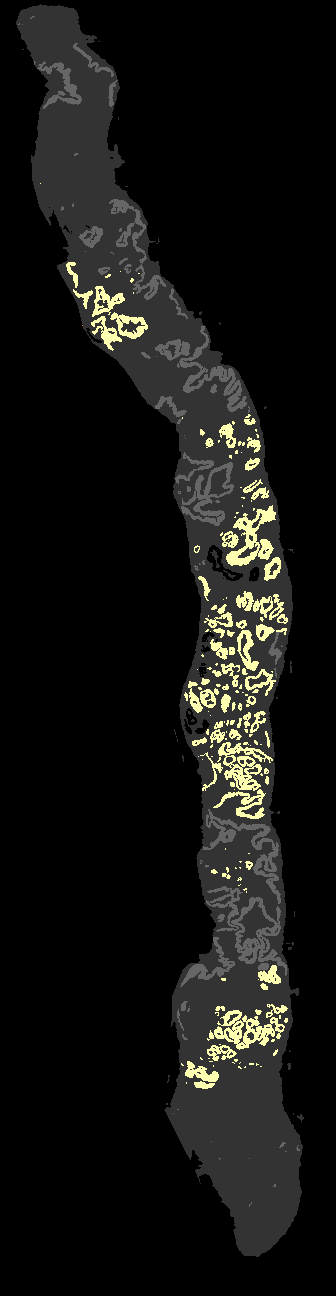

In [100]:
_ = display_mask(img_id='91939627c20f2e47fa4be433363bfd6d', center='radboud')

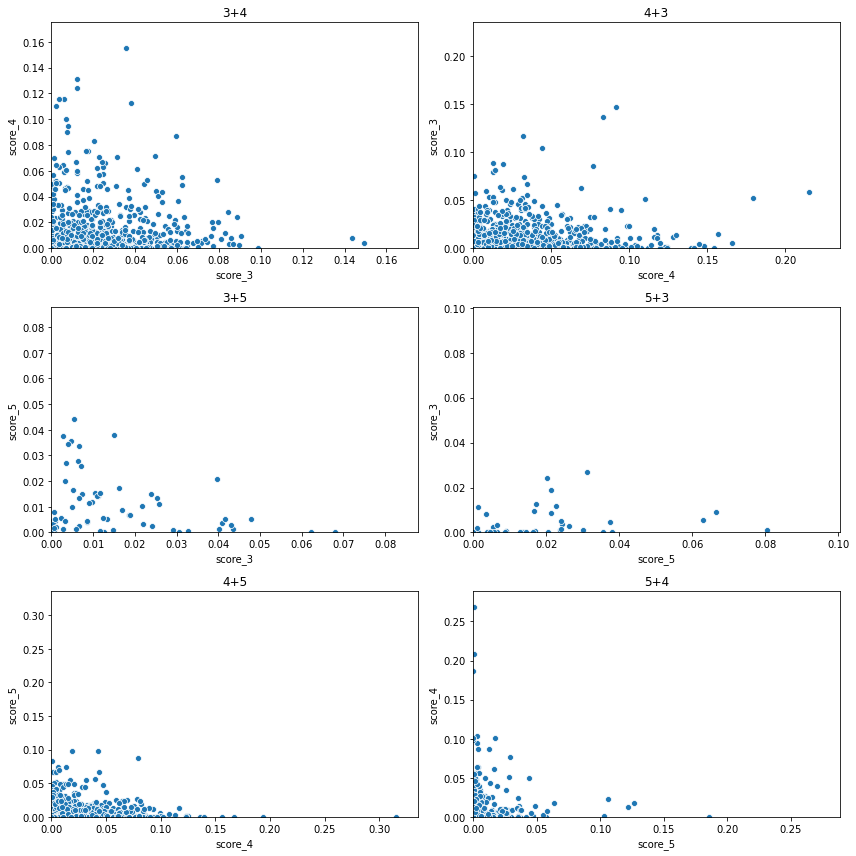

In [101]:
# Check Score_3~5 ScatterPlot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for score, ax in zip(['3+4', '4+3', '3+5', '5+3', '4+5', '5+4'], axes.ravel()):

    p = score.split('+')[0]
    s = score.split('+')[1]
    temp = df[df['gleason_score'] == score].reset_index(drop=True)
    lim = max(temp[f'score_{p}'].max(), temp[f'score_{s}'].max())

    sns.scatterplot(x=f'score_{p}', y=f'score_{s}', data=temp, ax=ax)
    ax.set_xlim(0, lim+0.02)
    ax.set_ylim(0, lim+0.02)
    ax.set_title(score)
    
plt.tight_layout()
plt.show()

---
### 3+4

In [102]:
temp = df[df['gleason_score'] == '3+4']
temp.shape

(673, 10)

In [103]:
temp[temp['score_5'] != 0].shape

(0, 10)

In [104]:
temp = df[df['gleason_score'] == '3+4']
temp['score_3_4'] = temp['score_3'] - temp['score_4']
temp = temp[temp['score_3_4'] < -0.004].copy()


temp = temp.sort_values(by='score_3_4').reset_index(drop=True)
temp.shape

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(143, 11)

In [105]:
temp = df[df['gleason_score'] == '4+3']
temp['score_4_3'] = temp['score_4'] - temp['score_3']
temp = temp[temp['score_4_3'] < -0.004].copy()


temp = temp.sort_values(by='score_4_3').reset_index(drop=True)
temp.shape

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(161, 11)

In [106]:
temp = df[df['gleason_score'] == '4+5']
temp['score_4_5'] = temp['score_4'] - temp['score_5']
temp = temp[temp['score_4_5'] < -0.004].copy()


temp = temp.sort_values(by='score_4_5').reset_index(drop=True)
temp.shape

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(90, 11)

In [107]:
temp = df[df['gleason_score'] == '5+4']
temp['score_5_4'] = temp['score_5'] - temp['score_4']
temp = temp[temp['score_5_4'] < -0.004].copy()


temp = temp.sort_values(by='score_5_4').reset_index(drop=True)
temp.shape

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(100, 11)

In [108]:
temp = df[df['gleason_score'] == '3+5']
temp['score_3_5'] = temp['score_3'] - temp['score_5']
temp = temp[temp['score_3_5'] < -0.004].copy()


temp = temp.sort_values(by='score_3_5').reset_index(drop=True)
temp.shape

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(18, 11)

In [109]:
temp = df[df['gleason_score'] == '5+3']
temp['score_5_3'] = temp['score_5'] - temp['score_3']
temp = temp[temp['score_5_3'] < -0.004].copy()


temp = temp.sort_values(by='score_5_3').reset_index(drop=True)
temp.shape

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2, 11)

In [110]:
temp.head()

,image_id,score_0,score_1,score_2,score_3,score_4,score_5,data_provider,isup_grade,gleason_score,score_5_3
0,08b92dd5bd510ff336949f1042c11991,0.908982,0.071673,0.006729,0.011344,0.0,0.001272,radboud,4,5+3,-0.010071
1,72b46ce40040292c972e5c8fc84f857d,0.912270,0.069758,0.006289,0.008177,0.0,0.003506,radboud,4,5+3,-0.004671


In [111]:
def check_wrong(df, th=-0.004):
    _df = df.copy()
    res = {}
    
    for score in ['3+4', '4+3', '3+5', '5+3', '4+5', '5+4']:
        p = score.split('+')[0]
        s = score.split('+')[1]
        temp = df[df['gleason_score'] == score]
        # 優位と劣勢の差分を取る
        temp[f'score_{p}_{s}'] = temp[f'score_{p}'] - temp[f'score_{s}']
        # 差分がマイナスならスコアが間違っている
        temp = temp[temp[f'score_{p}_{s}'] < th].reset_index(drop=True)
        
        for k in temp['image_id']:
            res[k] = s + '+' + p
            
    # 極端にガンの部分が少ない場合は削除する
    temp = df.copy()
    temp['score_345'] = temp['score_3'] + temp['score_4'] + temp['score_5']
    temp = temp[temp['score_345'] < 0.0003].reset_index(drop=True)
    
    for k in temp['image_id']:
        res[k] = '0+0'
        
    
    # gleason_score = "negative"を変換
    temp = df.copy()
    temp = temp[temp['gleason_score'] == 'negative'].reset_index(drop=True)
    
    for k in temp['image_id']:
        res[k] = '0+0'
    
            
    return res

In [112]:
res = check_wrong(df)

len(res)

d:\python\kaggle\prosta~1\venv~1\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


1599

In [113]:
df_org = pd.read_csv('../data/input/train.csv')
new_train = df_org.copy()


new_train['new'] = new_train['image_id'].map(res)



def rep_score(row):
    if row['new'] is np.nan:
        return row['gleason_score']
    else:
        return row['new']
    
new_train['new'] = new_train.apply(rep_score, axis=1)



rep_dict = {
    'negative': 0,
    '0+0': 0,
    '3+3': 1,
    '3+4': 2,
    '4+3': 3,
    '4+4': 4,
    '3+5': 4,
    '5+3': 4,
    '4+5': 5,
    '5+4': 5,
    '5+5': 5
}

new_train['new_grade'] = new_train['new'].map(rep_dict)

new_train.drop(['new', 'isup_grade'], axis=1, inplace=True)
new_train = new_train.rename(columns={'new_grade': 'isup_grade'})
new_train['isup_grade'] = new_train['isup_grade'].astype(int)

new_train.to_csv('../data/input/modified_train.csv', index=False)

In [114]:
new_train.head()

,image_id,data_provider,gleason_score,isup_grade
0,0005f7aaab2800f6170c399693a96917,karolinska,0+0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4+4,4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0+0,0


In [115]:
new_train[new_train['isup_grade'].isnull()]

,image_id,data_provider,gleason_score,isup_grade
